## Lab 7 (Image Processing using Convolutional Neural Networks)
- CIFAR10 dataset (see https://www.cs.toronto.edu/~kriz/cifar.html for more info)
- 60K images: 50K train, 10K test
- 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Perform multi-class classification with evaluation accuracy on EACH class

**CONNECT TO GPU** before continuing, but just CPU is also fine, it might be a bit slow.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them / normalize: image = (image - mean)/std / (mean1,mean2,mean3), (std1,std2,std3) for each channel.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Q1. Why are there 3 values in each list of the Normalize() function? What does each value and each list represent?
# The three values in each list of the Normalize() function correspond to the mean and standard deviation for the three color channels (Red, Green, Blue) in a colored image.
# The first three values represent the mean of each channel, ch1_mean, ch2_mean, ch3_mean and the next three values represent the standard deviation of each channel, ch1_std, ch2_std, ch3_std

cuda
Files already downloaded and verified
Files already downloaded and verified


### Inspect the Images

In [4]:
# Access the first data sample in the train_set using next(iter())
batch = next(iter(train_loader))
print(f'Image values: \n{batch}')
print(f'Length: {len(batch)}')
print(f'Type: {type(batch)}')

# This means the data contains image-label pairs
# Unpack them
images, labels = batch
# Same as these two lines:
# image = batch[0]
# label = batch[1]


print(f'Images shape: {images.shape}')
print(f'Lables: {labels}')

# Q2. What is the range of the values for the normalised image pixels?
# the range 0..1

# Q3. What does each index value of the shape of the image represent?
# Images shape: torch.Size([4, 3, 32, 32])
# 4: # of images, 3: # of channels, 32, 32: 32 x 32 (height and width) pixels.

# Q4. What do the label values represent?
#'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
# tensor([2, 9, 1, 2]), each number indicates 2-'bird', 9-'truck',and 1-'car',respectively

Image values: 
[tensor([[[[-0.6863, -0.6549, -0.6706,  ..., -0.8431, -0.8510, -0.8510],
          [-0.6784, -0.6627, -0.6706,  ..., -0.8431, -0.8510, -0.8431],
          [-0.6863, -0.6627, -0.6627,  ..., -0.8431, -0.8510, -0.8510],
          ...,
          [-0.7255, -0.7176, -0.6863,  ..., -0.8431, -0.8353, -0.8431],
          [-0.7020, -0.6863, -0.7020,  ..., -0.8118, -0.7882, -0.8039],
          [-0.7176, -0.7020, -0.7020,  ..., -0.6784, -0.7020, -0.7882]],

         [[-0.7255, -0.6941, -0.7176,  ..., -0.8510, -0.8588, -0.8588],
          [-0.7255, -0.7098, -0.7098,  ..., -0.8510, -0.8588, -0.8510],
          [-0.7255, -0.7020, -0.7020,  ..., -0.8510, -0.8588, -0.8588],
          ...,
          [-0.7333, -0.7176, -0.7098,  ..., -0.8431, -0.8353, -0.8353],
          [-0.6941, -0.6784, -0.7176,  ..., -0.7804, -0.7804, -0.8118],
          [-0.7098, -0.6863, -0.7098,  ..., -0.6392, -0.6784, -0.7725]],

         [[-0.8824, -0.8588, -0.8588,  ..., -0.8902, -0.8980, -0.8980],
          [-0.

### View some images
- Note that images have been normalised and may not look very clear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([2, 9, 1, 2])


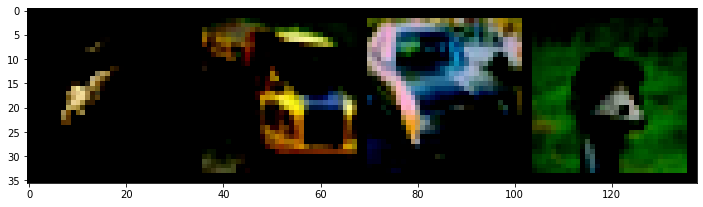

In [5]:
# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
# grid.permute(1,2,0) = [axis 1 x axis 2 x axis 0] = [image heigth x image width x # color channels]
plt.imshow(grid.permute(1,2,0))

## CNN model

In [30]:
class Test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) #inchannel(3 for color), outchannel, kernel, stride, padding / 32x32 
    self.relu = nn.ReLU() #28x28
    self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride / 14x14
    self.conv2 = nn.Conv2d(6, 16, 5) # 10x10 #pooling 5x5
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # Q8. Fill out the correct input dimensions 
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    print(f'Input shape: {x.shape}')
    out = self.conv1(x)
    print(f'After Conv1: {out.shape}')
    print(f'Padding: {self.conv1.padding}')
    out = self.pool(F.relu(out))
    print(f'After Pool1: {out.shape}')
    out = self.conv2(out)
    print(f'After Conv2: {out.shape}')
    out = self.pool(F.relu(out))
    print(f'After Pool2: {out.shape}')
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # Q8. Fill out the correct dimension after -1
    print(f'Before fc1: {out.shape}')
    out = self.fc1(out)
    out = self.relu(out)
    print(f'After fc1: {out.shape}')
    out = self.fc2(out)
    out = self.relu(out)
    print(f'After fc2: {out.shape}')
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    print(f'After fc3: {out.shape}')
    return out


model = Test().to(device)
# Let's view the softmax output
probs = nn.Softmax(dim=1)


# Q5. What do the three arguments of the first convolutional layer, conv1 represent (3,6,5)? 
# Each number represents input channel(3 for color image), the number of output channels(6), and the filter size(5), respectively.

# Q6. Explain the arguments of the second convolutional layer, conv2 (6, 16, 5) 
# 6 - # of input units(should be matched the output size of the previous conv layer)
# 16 - # of output channels
# 5 - # of Kernel(filter) size

# Q7. Figure out the convolved image size after conv1
# Convolved image size = ((input_width - filter_size + 2 * padding) / stride) + 1
# ((32-5+2*0)/1) + 1 = 28

# Q8. Figure out the input size to the first fcn layer and fill out the code above in init() and forward()


### Run through a sample batch

In [31]:
sample = next(iter(train_loader))

images, labels = sample

images = images.to(device)
labels = labels.to(device)

output = model(images)
print(f'Output shape: {output.shape}')
print(f'Softmax outputs:\n {probs(output)}')


# Q9. Explain the shape of the output after conv1
# 4 images, 6 channels, 28x28 pixel sizes' image (through passed 5x5 filter size, the underlying image has changed(32x32 -> 28x28))

# Q10. What does the pooling do to the dimensions of the feature images here?
# Polling reduces dimensionality, through two poolings the dimension of images is reduced.

# Q11. Add padding=1 to conv1 and rerun the last two code cells. How did padding affect the dimensions of the feature images?
# before padding 28x28(after Conv1) -> after padding 30x30(after Conv1);
# from the original size 32x32, it is not much more reduced than before padding.
# i.e. By padding the original size can be restored.

# Q12. What is represented by each list returned by Softmax outputs?
# Each list shows the probability for each classes.


Input shape: torch.Size([4, 3, 32, 32])
After Conv1: torch.Size([4, 6, 28, 28])
Padding: (0, 0)
After Pool1: torch.Size([4, 6, 14, 14])
After Conv2: torch.Size([4, 16, 10, 10])
After Pool2: torch.Size([4, 16, 5, 5])
Before fc1: torch.Size([4, 400])
After fc1: torch.Size([4, 128])
After fc2: torch.Size([4, 64])
After fc3: torch.Size([4, 10])
Output shape: torch.Size([4, 10])
Softmax outputs:
 tensor([[0.1112, 0.1060, 0.1040, 0.1074, 0.1168, 0.0908, 0.0910, 0.0903, 0.0924,
         0.0902],
        [0.1104, 0.1058, 0.1051, 0.1073, 0.1158, 0.0909, 0.0907, 0.0899, 0.0932,
         0.0909],
        [0.1101, 0.1054, 0.1049, 0.1060, 0.1172, 0.0920, 0.0903, 0.0894, 0.0932,
         0.0913],
        [0.1100, 0.1067, 0.1052, 0.1060, 0.1172, 0.0908, 0.0901, 0.0902, 0.0928,
         0.0909]], device='cuda:0', grad_fn=<SoftmaxBackward0>)



### Let's Train!
- Now that we know and understand how CNNs work, let's put everything together for CIFAR-10 dataset
  - Download the data in batches and normalisation with shuffling
  - Build a model with 2 CNN layers containing ReLU and pooling
  - Passing the feature images to 3 fully connected layers (FCNs) also containing RELU activation
  - The final layer has 10 units to reprsent the number of output classes
  - Use Binary Cross Entropy Loss and SGD optimiser
  - Evaluate the model on the test data on EACH class

**IMPORTANT!** Fill out the missing code below before training 

In [32]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 3color(input channel), output channel, kernel size / from the 32x32
    self.relu = nn.ReLU() #after conv1, w/o padding, 28x28
    self.pool = nn.MaxPool2d(2, 2) #after pooling 14x14
    self.conv2 = nn.Conv2d(6, 16, 5) #after conv2, w/o padding, (4,3,10,10) -> after pooling (4,3,5,5)
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss() #Using softmax

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
opt = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = learning_rate)

In [33]:
print(images.shape)

torch.Size([4, 3, 32, 32])


## Training loop

In [39]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')



Epoch 1/4, Iteration 1000/12500, Loss=1.1767 
Epoch 1/4, Iteration 2000/12500, Loss=1.1336 
Epoch 1/4, Iteration 3000/12500, Loss=3.5651 
Epoch 1/4, Iteration 4000/12500, Loss=1.7984 
Epoch 1/4, Iteration 5000/12500, Loss=0.8648 
Epoch 1/4, Iteration 6000/12500, Loss=0.9948 
Epoch 1/4, Iteration 7000/12500, Loss=0.7898 
Epoch 1/4, Iteration 8000/12500, Loss=0.8731 
Epoch 1/4, Iteration 9000/12500, Loss=0.6699 
Epoch 1/4, Iteration 10000/12500, Loss=0.8129 
Epoch 1/4, Iteration 11000/12500, Loss=2.1317 
Epoch 1/4, Iteration 12000/12500, Loss=1.2251 
Epoch 2/4, Iteration 1000/12500, Loss=0.7543 
Epoch 2/4, Iteration 2000/12500, Loss=1.1872 
Epoch 2/4, Iteration 3000/12500, Loss=0.6914 
Epoch 2/4, Iteration 4000/12500, Loss=0.0865 
Epoch 2/4, Iteration 5000/12500, Loss=1.3930 
Epoch 2/4, Iteration 6000/12500, Loss=0.0812 
Epoch 2/4, Iteration 7000/12500, Loss=0.8999 
Epoch 2/4, Iteration 8000/12500, Loss=1.2965 
Epoch 2/4, Iteration 9000/12500, Loss=0.4113 
Epoch 2/4, Iteration 10000/1250

In [43]:
print(images.shape)

torch.Size([4, 3, 32, 32])


## Evaluation

In [40]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 63.58 %
Accuracy of plane: 61.6 %
Accuracy of car: 76.8 %
Accuracy of bird: 50.2 %
Accuracy of cat: 30.3 %
Accuracy of deer: 64.2 %
Accuracy of dog: 54.5 %
Accuracy of frog: 80.8 %
Accuracy of horse: 66.8 %
Accuracy of ship: 80.7 %
Accuracy of truck: 69.9 %


In [ ]:
# Q15. Why don't we need to reshape the input images when training and testing?
# For CNN in this case, due to our construction of model, there is no need to match the input and the batch size.

# Q16. Try to improve the model performance, e.g. by increasing the epochs, changing batch size, adding convolutions, etc.
# Provide the code chunk showing the improved accuracy on the test set below. What changes did you make?

# At first, I tried to increase epoch number by 1. The loss is smaller than before, however the overall performance is not changed better.
# Epoch 5/5, Iteration 12000/12500, Loss=0.6767 
# Test Accuracy of the WHOLE CNN = 62.5 %

# Secondly, I changed the batch size from 4 to 5. Actually it is worse than before.

# Finally, batch 4, num_epoch = 7
# Test Accuracy of the WHOLE CNN = 62.56 %


In [71]:
# Hyper parameters
num_epochs = 7
batch_size = 4
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [72]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 3color(input channel), output channel, kernel size / from the 32x32
    self.relu = nn.ReLU() #after conv1, w/o padding, 28x28
    self.pool = nn.MaxPool2d(2, 2) #after pooling 14x14
    self.conv2 = nn.Conv2d(6, 16, 5) #after conv2, w/o padding, (4,3,10,10) -> after pooling (4,3,5,5)
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss() #Using softmax

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
opt = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = learning_rate)

In [73]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1250 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')


Epoch 1/7, Iteration 1250/12500, Loss=2.3369 
Epoch 1/7, Iteration 2500/12500, Loss=1.9722 
Epoch 1/7, Iteration 3750/12500, Loss=1.8611 
Epoch 1/7, Iteration 5000/12500, Loss=1.7155 
Epoch 1/7, Iteration 6250/12500, Loss=2.1511 
Epoch 1/7, Iteration 7500/12500, Loss=2.0897 
Epoch 1/7, Iteration 8750/12500, Loss=2.0916 
Epoch 1/7, Iteration 10000/12500, Loss=1.0624 
Epoch 1/7, Iteration 11250/12500, Loss=0.7826 
Epoch 1/7, Iteration 12500/12500, Loss=1.5612 
Epoch 2/7, Iteration 1250/12500, Loss=1.5103 
Epoch 2/7, Iteration 2500/12500, Loss=1.4062 
Epoch 2/7, Iteration 3750/12500, Loss=1.7410 
Epoch 2/7, Iteration 5000/12500, Loss=1.0264 
Epoch 2/7, Iteration 6250/12500, Loss=1.4982 
Epoch 2/7, Iteration 7500/12500, Loss=1.1684 
Epoch 2/7, Iteration 8750/12500, Loss=1.8656 
Epoch 2/7, Iteration 10000/12500, Loss=1.1123 


KeyboardInterrupt: ignored

In [67]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 59.46 %
Accuracy of plane: 55.4 %
Accuracy of car: 81.5 %
Accuracy of bird: 34.8 %
Accuracy of cat: 48.9 %
Accuracy of deer: 57.3 %
Accuracy of dog: 47.7 %
Accuracy of frog: 65.7 %
Accuracy of horse: 65.7 %
Accuracy of ship: 73.8 %
Accuracy of truck: 63.8 %
